In [1]:
import sys
import os
# Append the library path to PYTHONPATH, so library can be imported.
sys.path.append(os.path.dirname(os.getcwd()))
import datetime
import shutil

import numpy as np
import pandas as pd

from library import network as nw
from library import common as cm

Using TensorFlow backend.


In [2]:
%run setup.py
%load_ext autoreload
%autoreload 2

np.random.seed(RANDOM_SEED)

In [3]:
%run Load_Clean_aux.py
max_period = max([int(s[6:]) for s in df.columns if 'period' in s])

We remove samples when the next trade is not available. 163472 samples (4.52%) are removed. We have 95.48% of original data left, yielding a size of 3453492.
We remove unreasonable implvol0. 3159 samples (0.09%) are removed. We have 95.39% of original data left, yielding a size of 3450333.
We remove samples that have time to maturity less than 0 day. 0 samples (0.00%) are removed. We have 95.39% of original data left, yielding a size of 3450333.
We remove in-the-money samples. 712998 samples (20.66%) are removed. We have 75.68% of original data left, yielding a size of 2737335.
We shrink moneyness range. 104752 samples (3.83%) are removed. We have 72.78% of original data left, yielding a size of 2632583.


##### Choose features

In [4]:
if FEATURE_SET == 'delta_vega':
    ori_fea = ['delta_bs', '1_over_sqrt_tau', 'vega_n']
    sub_res = res_dir + 'Network/Delta_Vega/'
        
if VIX:
    ori_fea += ['fake_vix']

use_fea = [x + '_t' for x in ori_fea] + ['cp_int']

os.makedirs(sub_res, exist_ok=True)
shutil.copy(f'setup.py', sub_res)
print(f'Result PNL is stored at:\n{sub_res}')

Result PNL is stored at:
C:\Users\Weiguan\Dropbox\Research\01_DeepHedging\Data_OK\OptionMetrics\Result/FREQ=1D_HALFMONEY=otm_MINM=0.8_MAXM=1.5_MINTAU=0_Permute=False_VIX=True_MISSING=replace_missing_WINDOW=180D_KickTmrZeroVolume=False/Network/Delta_Vega/


##### Setup hypers and target
Here, we specify hyperparameters, which will be used for training at the next step.

In [5]:
hypers = {
    'nodes_per_layer': (30, 30),
    'reg_alpha': 1e-3,
    'lr': 1e-4,
    'epochs': 2,
    'outact': OUTACT
}

##### Train a network with given hypers



 Working on period 0.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 147081 samples, validate on 39802 samples
Epoch 1/2
147081/147081 [==============================] - 6s 39us/step - loss: 0.1726 - mean_squared_error: 0.1387 - val_loss: 0.0399 - val_mean_squared_error: 0.0087
Epoch 2/2
147081/147081 [==============================] - 5s 31us/step - loss: 0.0449 - mean_squared_error: 0.0164 - val_loss: 0.0319 - val_mean_squared_error: 0.0059


 Working on period 1.

Train on 152650 samples, validate on 54390 samples
Epoch 1/2
152650/152650 [==============================] - 6s 39us/step - loss: 0.0885 - mean_squared_error: 0.0530 - val_loss: 0.0385 - val_mean_squared_error: 0.0061
Epoch 2/2
152650/152650 [==============================] - 5s 33us/step - loss: 0.0425 - mean_squared_error: 0.0128 - val_loss: 0.0323 - val_mean_squared_error: 0.0053


 Working on period 2.

Train on 174025 samples, valida

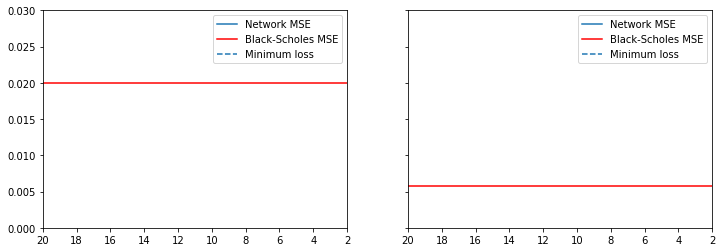

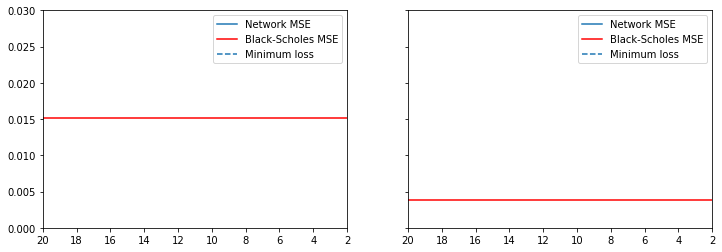

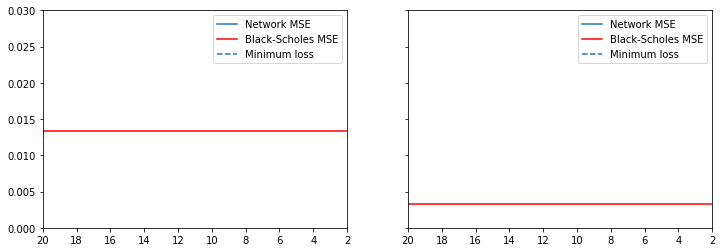

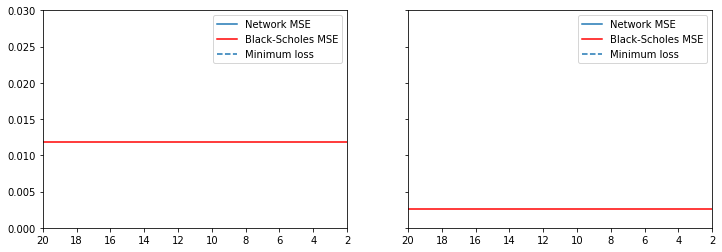

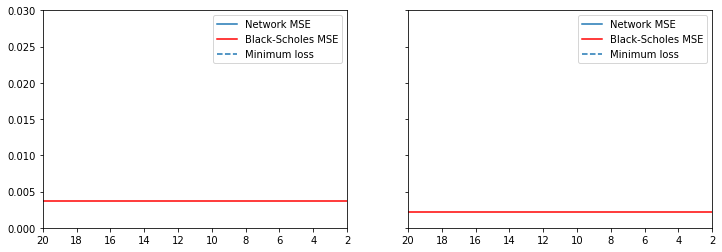

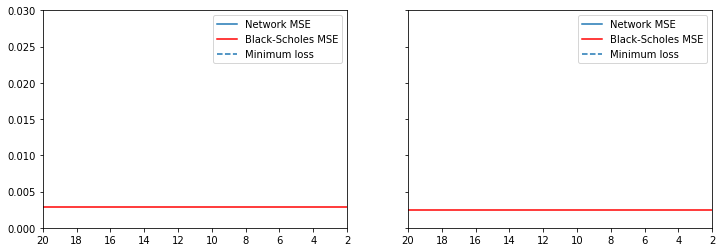

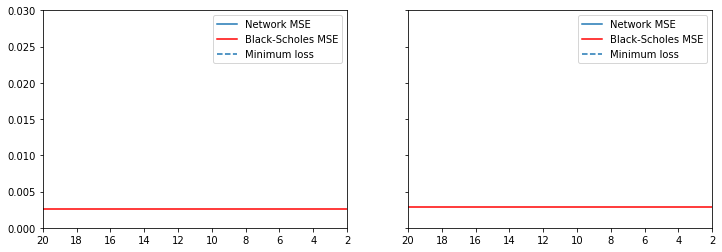

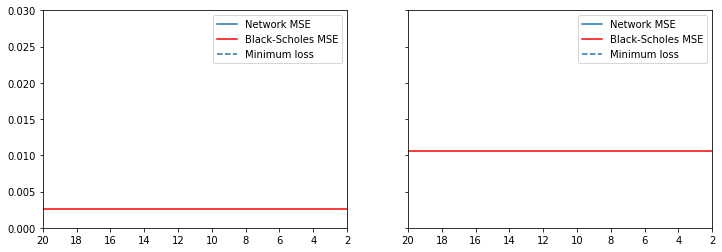

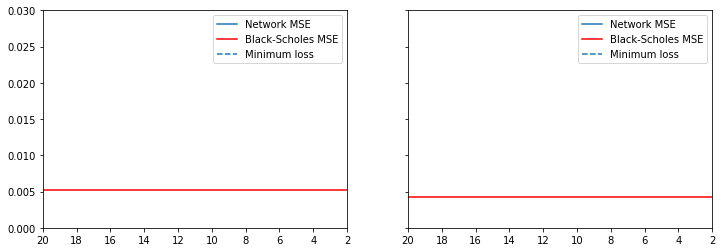

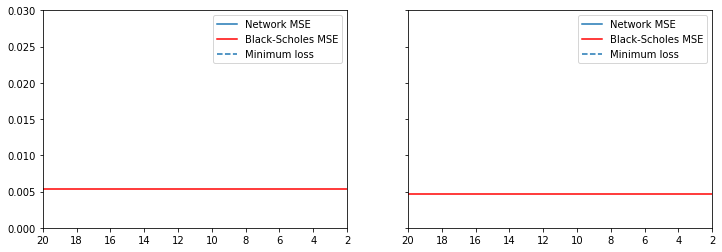

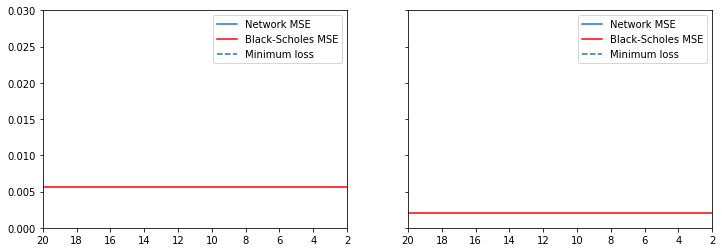

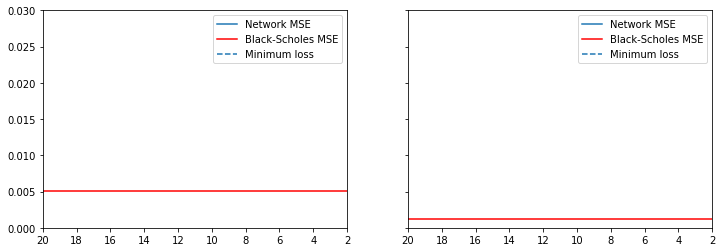

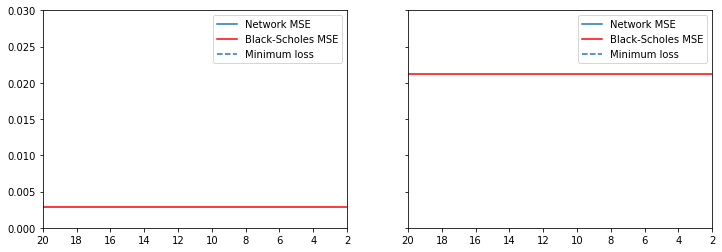

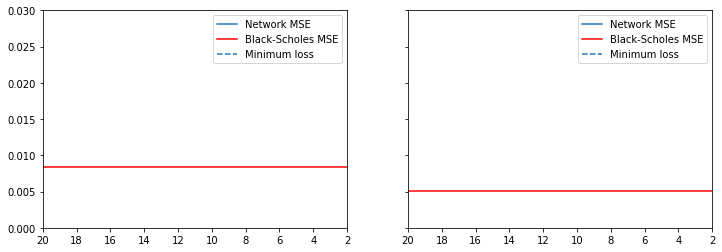

In [6]:
if not PERMUTE:
    """
    Here, we use a bit different structure as the simulation data.
    In case of no permutation, there are only one ckp, history, plot folder.
    In case of permuation, in each of ckp, history and plot, we have many permutation folders.

    As for the pnl folder:
    In case of no permutation, only one pnl file.
    in case of permutations, many pnl files.
    This is consistent as the regression folder.
    """
    sub_res_dir = {
        'ckp': sub_res + 'ckp/',
        'history': sub_res + 'history/',
        'pnl': sub_res + 'pnl/',
        'plot': sub_res + 'plot/'
    }
    for key, value in sub_res_dir.items():
        os.makedirs(value, exist_ok=True)

    df = nw.rolling_net(
        df,
        ori_fea=ori_fea,
        use_fea=use_fea,
        end_period=max_period,
        hypers=hypers,
        sub_res_dir=sub_res_dir
    )

    cm.store_pnl(df, df['delta_nn'], sub_res_dir['pnl'] + 'pnl.csv')
    

In [7]:
if PERMUTE:
    for p in range(NUM_PERMUTE):
        """
        We keep all the pnl in the same folder, because each
        permute only has one pnl files and we can use the same code 
        for evaluation.
        """
        sub_res_dir = {
            'ckp': sub_res + f'ckp/permute{p}/',
            'history': sub_res + f'history/permute{p}/',
            'pnl': sub_res + f'pnl/',
            'plot': sub_res + f'plot/permute{p}/'
        }
        for key, value in sub_res_dir.items():
            os.makedirs(value, exist_ok=True)
            
        df_permute = df.copy()
        df_permute = cm.rolling_permute(df_permute, random_seed=p+100)
        
        df_permute = nw.rolling_net(
            df_permute, 
            ori_fea=ori_fea, 
            use_fea=use_fea,
            end_period=max_period,
            hypers=hypers, 
            sub_res_dir=sub_res_dir)
        
        cm.store_pnl(df_permute, df_permute['delta_nn'], sub_res_dir['pnl'] + f'pnl{p}.csv')

In [8]:
# Copy data setup file from the clean data folder, and then append network setup.
with open(f'{sub_res}paras.txt', 'a') as file:
    file.write('\n\nThe following is network setup.\n')
    file.write(f'Date and time = {datetime.datetime.now()}\n')
    for n, x in [
        ('Learning rate', hypers['lr']),
        ('L2 regularization alpha', hypers['reg_alpha']),
        ('Output node activation', hypers['outact']),
        ('Nodes per layer', hypers['nodes_per_layer']),
        ('Number of training epochs', hypers['epochs']),
        ('Feature set', ori_fea)
    ]:
        file.write(f'{n} = {x}\n')